In [1]:
import random
import numpy as np

from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit, transpile, Aer, execute
from qiskit.utils import QuantumInstance
from qiskit.algorithms import Shor
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_bloch_vector, plot_histogram

## Qubit

C:\Users\mlabadm\AppData\Local\Programs\Python\Python39\lib\site-packages\qiskit\visualization\bloch.py:397: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  self.axes = Axes3D(self.fig, azim=self.view[0], elev=self.view[1])
C:\Users\mlabadm\AppData\Local\Programs\Python\Python39\lib\site-packages\qiskit\visualization\bloch.py:69: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  x_s, y_s, _ = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)


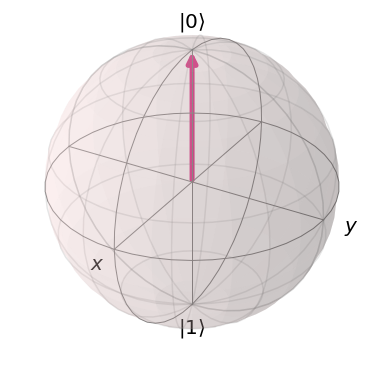

In [2]:
plot_bloch_vector([1,0,0], coord_type = "spherical")
#plot_bloch_vector([1,np.pi,0], coord_type = "spherical")
#plot_bloch_vector([1,np.pi/2,0], coord_type = "spherical")
#plot_bloch_vector([1,np.pi/2,np.pi/2], coord_type = "spherical")
#plot_bloch_vector([1,np.pi/2,np.pi], coord_type = "spherical")
#plot_bloch_vector([1,1.1*np.pi/3,np.pi/6], coord_type = "spherical")

## Quantum Gates

In [ ]:
state = Statevector.from_int(0, 2)
state.draw('latex')

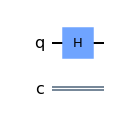

In [3]:
circ = QuantumCircuit(1,1)
circ.h(0)
circ.draw('mpl')

In [4]:
state = state.evolve(circ)
state.draw('latex')

<IPython.core.display.Latex object>

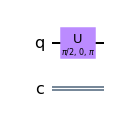

In [5]:
state = Statevector.from_int(0, 2)
circ = QuantumCircuit(1,1)
circ.u(np.pi/2,0,np.pi,0)
circ.draw('mpl')

In [6]:
state = state.evolve(circ)
state.draw('latex')

<IPython.core.display.Latex object>

## Quantum Circuits

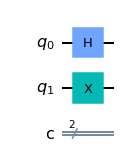

In [7]:
state = Statevector.from_int(0, 4)
circ = QuantumCircuit(2,2)
circ.h(0)
circ.x(1)
circ.draw('mpl')

In [8]:
state = state.evolve(circ)
state.draw('latex')

<IPython.core.display.Latex object>

## Superposition

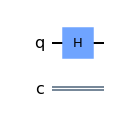

In [9]:
state = Statevector.from_int(0, 2)
circ = QuantumCircuit(1,1)
circ.h(0)
circ.draw('mpl')

In [10]:
backend = Aer.get_backend('statevector_simulator')
job = backend.run(circ)
result = job.result()
outputstate = result.get_statevector(circ, decimals=3)
print(outputstate)

[0.707+0.j 0.707+0.j]


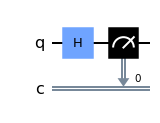

In [11]:
state = Statevector.from_int(0, 2)
circ = QuantumCircuit(1,1)
circ.h(0)
circ.measure(range(1), range(1))
circ.draw('mpl')

In [12]:
backend = Aer.get_backend('qasm_simulator')
qc_compiled = transpile(circ, backend)
job_sim = backend.run(qc_compiled, shots=1000)
result_sim = job_sim.result()
counts = result_sim.get_counts(qc_compiled)
print(counts)

{'1': 498, '0': 502}


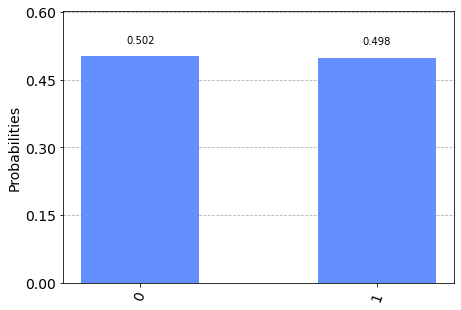

In [13]:
plot_histogram(counts)

## Entanglement

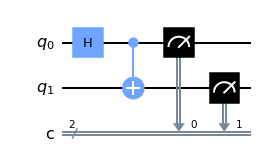

In [14]:
meas = QuantumCircuit(2, 2)
meas.h(0)
meas.cx(0, 1)
meas.measure([0,1], [0,1])
meas.draw('mpl')

In [15]:
backend = Aer.get_backend('qasm_simulator')
qc_compiled = transpile(meas, backend)
job_sim = backend.run(qc_compiled, shots=1000)
result_sim = job_sim.result()
counts = result_sim.get_counts(qc_compiled)
print(counts)

{'11': 496, '00': 504}


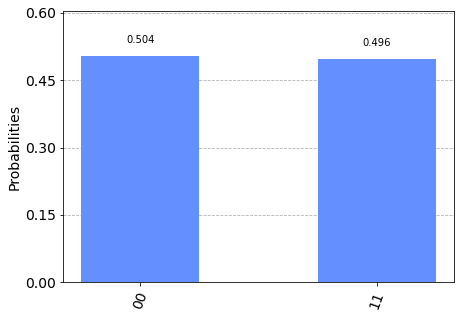

In [16]:
plot_histogram(counts)

## Teleportation

In [17]:
a1 = random.random()*2 -1 
a2 = random.random()*2 -1
b1 = random.random()*2 -1
b2 = random.random()*2 -1
norm = (a1**2 + a2**2 + b1**2 + b2**2)**0.5
c1 = complex(a1/norm,a2/norm) #Amplitude for |0> 
c2 = complex(b1/norm,b2/norm) #Amplitude for |1>

print("Alice's qubit is:")
print("{} |0> + {} |1>".format(c1, c2))

Alice's qubit is:
(0.21947977901713442-0.761144888689028j) |0> + (-0.5985951656266892-0.11904164277055937j) |1>


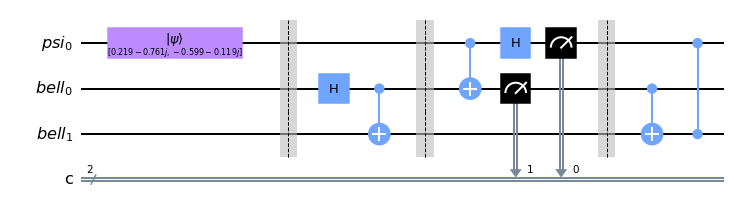

In [18]:
psi  = QuantumRegister(1, name = 'psi')   # The qubit to teleport
bell = QuantumRegister(2, name = 'bell')  # The shared entangled pair 
c    = ClassicalRegister(2, name = 'c')   # Two classical bits for the measures
teleport = QuantumCircuit(psi,bell,c)     # We create the circuit with the two quantum registers and the classical bits
teleport.initialize([c1,c2],psi)          # We set the amplitudes for Alice's quibt
teleport.barrier()
teleport.h(bell[0])
teleport.cx(bell[0],bell[1])
teleport.barrier()
teleport.cx(psi,bell[0])
teleport.h(psi)
teleport.measure([psi[0],bell[0]],c)
teleport.barrier()
teleport.cx(bell[0],bell[1])
teleport.cz(psi,bell[1])
teleport.draw(output='mpl')

In [19]:
backend = Aer.get_backend('statevector_simulator')
job = execute(teleport, backend)
outputstate = job.result().get_statevector()
outputstate = np.array([outputstate]).T
print("Bob's qubit is:")
print("{} |0> + {} |1>".format(outputstate[np.nonzero(outputstate)[0][0]], outputstate[np.nonzero(outputstate)[0][1]]))

Bob's qubit is:
[0.21947978-0.76114489j] |0> + [-0.59859517-0.11904164j] |1>


## Deutsch-Jozsa algorithm

In [20]:
n = 4                               # Number of qubits that we are going to use in the oracle
q   = QuantumRegister(n, 'q')       # The oracle qubits
out = QuantumRegister(1, 'out')     # Qubit for the oracle output
c   = ClassicalRegister(n, 'c')     # Classical bits needed for the result of the measurement
circ_init = QuantumCircuit(q,out,c) # Initial part of the circuit

for i in range(n):    
    circ_init.h(q[i]) # We apply H to all the oracle qubits
    
circ_init.x(out)    # We apply X and H to the output qubit
circ_init.h(out)
circ_init.barrier() # Visual barrier to separate the parts of the circuit

circ_end = QuantumCircuit(q,out,c)
circ_end.barrier()   # Visual barrier to separate the parts of the circuit
for i in range(n):    
    circ_end.h(q[i]) # We apply H to all the oracle qubits    
circ_end.measure(q,c)

const = QuantumCircuit(q,out,c)
const.cx(q[0],out)
const.x(q[0])
const.cx(q[0],out)
const.x(q[0])

bal = QuantumCircuit(q,out,c)
bal.cx(q[0],out)

C:\Users\mlabadm\AppData\Local\Temp/ipykernel_1076/2624247883.py:1: DeprecationWarning: The QuantumCircuit.__add__() method is being deprecated.Use the compose() method which is more flexible w.r.t circuit register compatibility.
  circ_const = circ_init + const + circ_end
C:\Users\mlabadm\AppData\Local\Programs\Python\Python39\lib\site-packages\qiskit\circuit\quantumcircuit.py:933: DeprecationWarning: The QuantumCircuit.combine() method is being deprecated. Use the compose() method which is more flexible w.r.t circuit register compatibility.
  return self.combine(rhs)


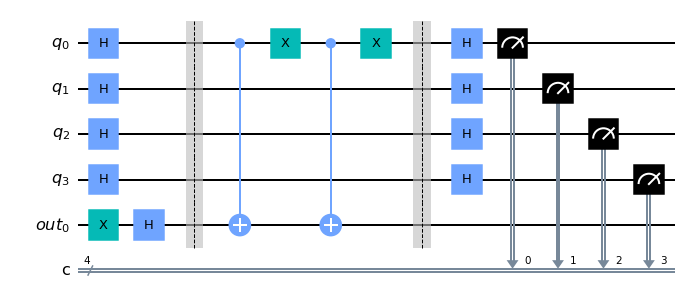

In [21]:
circ_const = circ_init + const + circ_end
circ_const.draw(output='mpl')

In [22]:
backend = Aer.get_backend('qasm_simulator')
job = execute(circ_const, backend, shots=1)
counts = job.result().get_counts()
print(counts)

{'0000': 1}


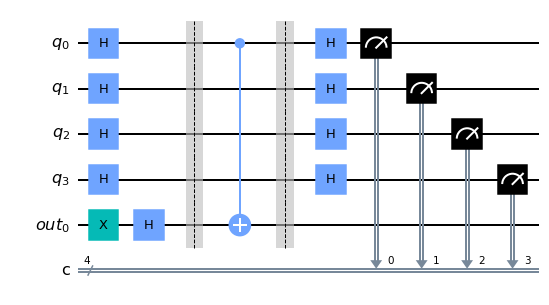

In [23]:
circ_bal = circ_init + bal + circ_end
circ_bal.draw(output='mpl')

In [24]:
job = execute(circ_bal, backend, shots=1)
counts = job.result().get_counts()
print(counts)

{'0001': 1}


## Shor

In [27]:
backend = Aer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend)
shor = Shor(quantum_instance=quantum_instance)
result = shor.factor(N=35, a=2)
print('Factors:', result.factors)

Factors: [[5, 7]]
